Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Epoch 1/10000
48/48 [==============================] - 72s 1s/step - loss: 3041996580.5714 - val_loss: 1426451328.0000
Epoch 2/10000
48/48 [==============================] - 71s 1s/step - loss: 1429467710.6939 - val_loss: 44443516.0000
Epoch 3/10000
48/48 [==============================] - 70s 1s/step - loss: 17418119.7143 - val_loss: 4938212.0000
Epoch 4/10000
48/48 [==============================] - 70s 1s/step - loss: 3993547.2857 - val_loss: 2258044.5000
Epoch 5/10000
48/48 [==============================] - 70s 1s/step - loss: 1803604.7730 - val_loss: 1238480.2500
Epoch 6/10000
48/48 [==============================] - 70s 1s/step - loss: 1790726.7194 - val_loss: 1041552.0625
Epoch 7/10000
48/48 [==============================] - 70s 1s/step - loss: 1116236.8189 - val_loss: 1058229.8750
Epoch 8/10000
48/48 [==============================] - 70s 1s/step 

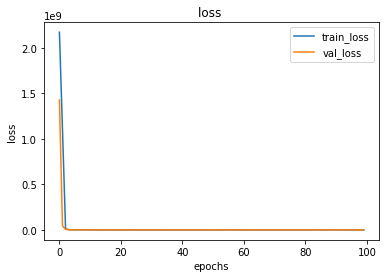

15/15 [==============================] - 4s 233ms/step - loss: 457274.5938
loss :  457274.59375


In [6]:
import os
from google.colab import drive
drive.mount('/content/drive/')
# '/content/drive/My Drive/Study/modelCheckpoint/____________________k46_boston_{epoch:02d}-{val_loss:.4f}.hdf5'

import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Conv1D,MaxPool1D,Dropout,Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 함수정의
def split_x(seq,size,col):
    aaa=[]
    for i in range(len(seq)-size+1):
        subset = seq[i:(i+size),0:col].astype('float32')
        aaa.append(np.array(subset))
    return np.array(aaa)

def str_to_float(input_str):
    temp = input_str
    if temp[0]!='-':
        temp = input_str.split(',')
        sum = 0
        for i in range(len(temp)):
            sum+=float(temp[-i-1])*(10**(i*3))
        return sum
    else:
        temp=temp[1:]
        temp = input_str.split(',')
        sum = 0
        for i in range(len(temp)):
            sum+=float(temp[-i-1])*(10**(i*3))
        return -sum


datasets = pd.read_csv("/content/drive/My Drive/Study/test/삼성전자.csv",encoding='cp949',index_col=0)

#전처리 
#1-1 분할(결측치가 있는 3개의행 제거)
datasets_1 = datasets.iloc[:662,:]
datasets_2 = datasets.iloc[665:,:]

datasets = pd.concat([datasets_1,datasets_2])

# 50으로 나누고 곱함
# str -> florat


#필요한 열에 타입변환 및 순서 바꿈
for j in [0,1,2,3,5,6,8,9,10,11,12]:
    for i in range(len(datasets.iloc[:,j])):
        datasets.iloc[i,j] = str_to_float(datasets.iloc[i,j])
datasets.iloc[662:,0:4] = datasets.iloc[662:,0:4]/50.0
datasets.iloc[662:,5] = datasets.iloc[662:,5]*50
datasets = datasets.iloc[::-1,:]
datasets.to_csv('/content/drive/My Drive/Study/test/csv.csv')
datasets = pd.read_csv('/content/drive/My Drive/Study/test/csv.csv',index_col=0)
datasets.drop(['거래량', '금액(백만)','신용비','외국계','프로그램'], axis='columns', inplace=True)
np.save("/content/drive/My Drive/Study/test/삼성전자.npy",arr=datasets)
#y데이터 생성
size=20
col=9

y = datasets.iloc[size-1:,3].values #(2378,)


#MinMax
scaler = MinMaxScaler()
datasets_minmaxed = scaler.fit_transform(datasets)

#train_test_split
x = split_x(datasets_minmaxed,size,col) # (2378,20,14)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2)

x_train=x_train.reshape(-1,size,col).astype('float32')
x_test=x_test.reshape(-1,size,col).astype('float32')
x_val=x_val.reshape(-1,size,col).astype('float32')

modelpath = "../data/h5/Samsung_best_model.h5"
es = EarlyStopping(monitor = 'val_loss',patience=20)
cp = ModelCheckpoint(monitor = 'val_loss',filepath = modelpath,save_best_only=True)
model = Sequential()
model.add(LSTM(1024,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(8192,activation='relu'))
model.add(Dense(4096,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam')

hist = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10000,batch_size=32,verbose=1,callbacks=[es,cp])

plt.rc('font', family='Malgun Gothic')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss','val_loss'])
plt.show()

loss = model.evaluate(x_test,y_test,batch_size=32)
print("loss : ",loss )



